In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import os


import gc
import pickle as pickle

from sklearn.model_selection import KFold

from catboost import CatBoostRegressor
import lightgbm as lgbm

import itertools

import multiprocessing as mp
import importlib
from sklearn.model_selection import train_test_split

In [3]:
#tail -n +2 train.csv | split -l 150000
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

In [4]:
from os import listdir
from os.path import isfile, join

TRAIN_SPLITS='train'
splits = [f for f in listdir(TRAIN_SPLITS) if isfile(join(TRAIN_SPLITS, f))]

In [5]:
TIMESTEPS=1

import build_segment
importlib.reload(build_segment)

from build_segment import build_segment_f

split_chunks = np.array_split(splits,mp.cpu_count())

#def build_segment_f(splits, number_of_groups,test=False, augment=False, scale=True, noise=0.5):

param_test = False
param_augment = False
param_scale = False
param_noise = 0.9


if __name__ ==  '__main__':
    pool = mp.Pool(mp.cpu_count())
    res = [pool.apply_async(build_segment_f,args=[chunk,TIMESTEPS,param_test,param_augment,param_scale,param_noise]) for chunk in split_chunks]
    pool.close()
    pool.join()

0
0
0
0
0
0
0
0
100
100
100
100
100
100
100
100
200
200
200
200
200
200
200
200
300
300
300
300
300
300
300
300
400
400
400
400
400
400
400
400
500
500
500
500
500
500
500
500


In [16]:
res[0].get()[100]

,mean,max,min,std,abs,q25,q50,q75,sum,uniq,pos,negs,ssum,imax,imin,abs_nrg,abs_sum_chg,autocorr_10,cid_ce,kurtosis,mean_chg,reocurring_pct,r_sigma,ratio_to_length,skewness,strike_below,strike_above,last_loc_max,first_loc_max,last_loc_min,first_loc_min,perc_reocurr_dp,perc_reocurr_all,sum_reoccurr_val,sum_reoccurr_dp,ratio_value_number,peaks,mean_head,mean_tail,abs_diff_head_tail,pos_head,neg_head,pos_tail,neg_tail,time_to_failure,augmented
0,4.444313,240.0,-251.0,6.772888,491.0,2.0,4.0,7.0,666647.0,258.0,130706.0,12757.0,805813.0,123721.0,123730.0,9843589.0,398960.0,-0.501602,211.444229,196.416366,0.000013,0.744186,0.021727,0.00172,-0.913277,28.0,27.0,0.824813,0.824807,0.824873,0.824867,0.744186,0.99956,525.0,666440.0,0.00172,40.0,4.824,4.483,45.0,707.0,254.0,881.0,85.0,3.150997,False


In [6]:
columns=res[0].get()[0].columns.values

data = pd.DataFrame(columns=columns)


i=0
for r in res:
    for df in r.get():
        data = data.append(df)
        i+=1
        

data.reset_index(drop=True,inplace=True)


In [9]:

data.sample(10)

,mean,max,min,std,abs,q25,q50,q75,sum,uniq,pos,negs,ssum,imax,imin,abs_nrg,abs_sum_chg,autocorr_10,cid_ce,kurtosis,mean_chg,reocurring_pct,r_sigma,ratio_to_length,skewness,strike_below,strike_above,last_loc_max,first_loc_max,last_loc_min,first_loc_min,perc_reocurr_dp,perc_reocurr_all,sum_reoccurr_val,sum_reoccurr_dp,ratio_value_number,peaks,mean_head,mean_tail,abs_diff_head_tail,pos_head,neg_head,pos_tail,neg_tail,time_to_failure,augmented,segment
3064,4.643867,73.0,-61.0,3.987769,134.0,3.0,5.0,7.0,696580.0,117.0,135937.0,8275.0,757508.0,72392.0,63848.0,5620170.0,376861.0,-0.326331,312.661925,22.240299,0.000060,0.854701,0.031933,0.000780,0.085846,19.0,23.0,0.482620,0.482613,0.425660,0.425653,0.854701,0.999887,348.0,696098.0,0.000780,47.0,4.741,4.810,25.0,833.0,110.0,886.0,73.0,12.733397,False,xzeio
1629,4.891307,112.0,-101.0,5.069033,213.0,3.0,5.0,7.0,733696.0,155.0,133960.0,10626.0,835534.0,100215.0,100223.0,7442996.0,392408.0,-0.431684,260.905044,33.524518,0.000013,0.800000,0.032847,0.001033,-0.038370,19.0,25.0,0.668107,0.668100,0.668160,0.668153,0.800000,0.999793,509.0,733254.0,0.001033,41.0,5.322,4.968,19.0,956.0,21.0,943.0,21.0,9.696996,False,xrg
2691,4.667487,150.0,-90.0,5.349547,240.0,2.0,5.0,7.0,700123.0,177.0,132397.0,11505.0,810901.0,143210.0,37736.0,7560463.0,391036.0,-0.419792,247.991951,53.330164,-0.000013,0.824859,0.029167,0.001180,0.779980,24.0,31.0,0.954740,0.954733,0.251580,0.251573,0.824859,0.999793,1251.0,699290.0,0.001180,50.0,4.520,5.005,21.0,932.0,27.0,918.0,54.0,5.137698,False,xvt
3951,4.542147,243.0,-210.0,7.470333,453.0,2.0,5.0,7.0,681322.0,280.0,130531.0,13318.0,851086.0,120351.0,120342.0,11465546.0,409913.0,-0.517219,201.575079,155.520072,-0.000060,0.717857,0.025127,0.001867,0.240547,33.0,34.0,0.802347,0.802340,0.802287,0.802280,0.717857,0.999473,997.0,680780.0,0.001867,49.0,4.526,4.328,20.0,868.0,70.0,876.0,82.0,3.318796,False,xzcgl
2668,4.731200,105.0,-89.0,5.096663,194.0,3.0,5.0,7.0,709680.0,165.0,134258.0,10078.0,805816.0,31573.0,31618.0,7254034.0,389248.0,-0.438253,259.584952,43.378283,-0.000027,0.830303,0.029287,0.001100,0.053329,24.0,25.0,0.210493,0.210487,0.210793,0.210787,0.830303,0.999813,534.0,709710.0,0.001100,46.0,4.903,5.006,18.0,947.0,20.0,956.0,15.0,10.632196,False,xqi
1020,4.185240,148.0,-90.0,3.418934,238.0,2.0,4.0,6.0,627786.0,121.0,135901.0,7498.0,669528.0,81286.0,81277.0,4380802.0,366743.0,-0.248424,354.375849,115.698288,-0.000020,0.710744,0.023733,0.000807,1.232481,21.0,20.0,0.541913,0.541907,0.541853,0.541847,0.710744,0.999767,52.0,627338.0,0.000807,41.0,4.731,4.555,17.0,935.0,26.0,940.0,28.0,8.789199,False,xzevu
3672,4.597953,126.0,-117.0,6.328488,243.0,2.0,5.0,7.0,689693.0,182.0,127876.0,15600.0,859743.0,108845.0,108834.0,9178641.0,411467.0,-0.487239,222.517467,38.297358,-0.000087,0.829670,0.034947,0.001213,-0.294414,28.0,24.0,0.725640,0.725633,0.725567,0.725560,0.829670,0.999793,193.0,689722.0,0.001213,47.0,4.633,4.624,23.0,850.0,82.0,896.0,57.0,0.846696,False,xap
2830,4.315687,52.0,-44.0,3.142984,96.0,2.0,4.0,6.0,647353.0,73.0,135930.0,7537.0,683071.0,129823.0,129882.0,4275525.0,365867.0,-0.191543,381.220472,6.807165,-0.000020,0.863014,0.046300,0.000487,0.013886,22.0,17.0,0.865493,0.865487,0.865887,0.865880,0.863014,0.999933,316.0,647388.0,0.000487,50.0,4.361,3.999,22.0,914.0,43.0,873.0,62.0,14.933897,False,xzbne
1324,4.344767,70.0,-68.0,4.230174,138.0,2.0,4.0,6.0,651715.0,117.0,133081.0,10394.0,732695.0,64967.0,75942.0,5515705.0,381380.0,-0.352936,299.893315,20.128079,0.000053,0.854701,0.034333,0.000780,0.021851,22.0,20.0,0.939853,0.433113,0.506287,0.506280,0.854701,0.999887,465.0,651822.0,0.000780,41.0,4.360,4.301,29.0,929.0,35.0,819.0,142.0,6.357498,False,xzcdl
212,4.274520,81.0,-58.0,4.215539,139.0,2.0,4.0,6.0,641178.0,117.0,132487.0,10678.0,723068.0,1444.0,1436.0,5406344.0,380375.0,-0.357197,299.299486,20.464042,-0.000020,0.854701,0.034553,0.000780,0.079068,25.0,22.0,0.009640,0.009627,0.009580,0.009573,0.854701,0.999887,305.0,640924.0,0.000780,42.0,4.090,4.433,38.0,685

In [12]:
for column in data.columns.values:
    #col_mean = data[column].mean()
    if "augmented" not in column:
        data[f'log_{column}'] =  np.log(data[column])

/home/shemery/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/home/shemery/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


In [85]:
combinations2 = list(itertools.combinations(data.columns.values, 2))
combinations3 = list(itertools.combinations(data.columns.values, 3))


In [86]:

for combination in combinations2:
    if 'augmented' in combination or 'time_to_failure' in combination:
        continue
    f1 = combination[0]
    f2 = combination[1]
    feature = f'{f1}_mult_{f2}'
    data[feature] = data[f1] * data[f2]
    feature = f'{f1}_plus_{f2}'
    data[feature] = data[f1] + data[f2]
    feature = f'{f1}_div_{f2}'
    #print(feature)
    data[feature] = data[f1] / data[f2]
    data[feature] = pd.to_numeric(data[feature], downcast='float')


In [17]:

for combination in combinations3:
    if 'augmented' in combination or 'time_to_failure' in combination:
        continue
    f1 = combination[0]
    f2 = combination[1]
    f3 = combination[2]
    feature = f'{f1}_mult_{f2}_mult_{f3}'
    data[feature] = data[f1] * data[f2] * data[f3]
    feature = f'{f1}_plus_{f2}_plus_{f3}'
    data[feature] = data[f1] + data[f2] + data[f3]
    feature = f'{f1}_div_{f2}_div_{f3}'
    #print(feature)
    data[feature] = data[f1] / data[f2] / data[f3]
    data[feature] = pd.to_numeric(data[feature], downcast='float')
    

In [10]:
splits

shared_train_data, shared_val_data = train_test_split(splits, test_size=0.1, random_state=42)

import pickle

pickle.dump(shared_train_data, open( "shared_train_data.pickle", "wb" ))
pickle.dump(shared_val_data, open( "shared_val_data.pickle", "wb" ))

In [11]:


training__ = data[data['segment'].isin(shared_train_data)]
train_y = training__['time_to_failure']
train_data = training__.drop(['segment', 'augmented', 'time_to_failure'], axis=1)

validation__ = data[data['segment'].isin(shared_val_data)]
val_y = validation__['time_to_failure']
val_data = validation__.drop(['segment', 'augmented', 'time_to_failure'], axis=1)

#test_size = 0.1
#train_data, val_data, y_train, y_val = train_test_split(data, targets, test_size=test_size, random_state=42)

# val_size = int(len(data)*0.1)
# non_augmented = data[data['augmented'] == False]
# val_indices = np.random.choice(non_augmented.index.values, val_size)
# val_data = data[data.index.isin(val_indices)].drop('augmented', axis=1)
# train_data = data[~data.index.isin(val_indices)].drop('augmented', axis=1)

# train_y = train_data['time_to_failure']
# val_y = val_data['time_to_failure']

# train_data = train_data.drop('time_to_failure', axis=1)
# val_data = val_data.drop('time_to_failure', axis=1)

In [12]:
len(val_data)

420

In [ ]:
list(all_features)

In [13]:
all_features = train_data.columns.values
cb_features = all_features
lg_features = all_features

In [25]:

cb_model = CatBoostRegressor(iterations=10000,
                             #learning_rate=0.05,
                             eval_metric='MAE',
                             #task_type = "GPU",
                             use_best_model=True,
                             od_type = "Iter",
                             od_wait = 10,
                             #depth=3,
                             #border_count=254,
                             #bagging_temperature = 3,
                             #cat_features=[0],
                             random_seed = 42)



cb_model.fit(train_data[cb_features], train_y, #cat_features=categorical_features_indices,
             eval_set=(val_data[cb_features],val_y),
             #cat_features=categorical_features_pos,         
             verbose=True)

cb_scores = {}
for i,score in enumerate(cb_model.get_feature_importance()):
    cb_scores[cb_features[i]] = score

sorted(cb_scores.items(), key=lambda x: x[1])[::-1]

0:	learn: 5.5266256	test: 5.4635058	best: 5.4635058 (0)	total: 23.1ms	remaining: 3m 51s
1:	learn: 5.3721537	test: 5.3167075	best: 5.3167075 (1)	total: 33.6ms	remaining: 2m 47s
2:	learn: 5.2230788	test: 5.1717322	best: 5.1717322 (2)	total: 41.4ms	remaining: 2m 17s
3:	learn: 5.0792584	test: 5.0312715	best: 5.0312715 (3)	total: 47.9ms	remaining: 1m 59s
4:	learn: 4.9419461	test: 4.8955398	best: 4.8955398 (4)	total: 53.9ms	remaining: 1m 47s
5:	learn: 4.8092755	test: 4.7650990	best: 4.7650990 (5)	total: 59.9ms	remaining: 1m 39s
6:	learn: 4.6819599	test: 4.6425422	best: 4.6425422 (6)	total: 66.2ms	remaining: 1m 34s
7:	learn: 4.5603705	test: 4.5255815	best: 4.5255815 (7)	total: 72.4ms	remaining: 1m 30s
8:	learn: 4.4448026	test: 4.4135813	best: 4.4135813 (8)	total: 78.4ms	remaining: 1m 27s
9:	learn: 4.3332481	test: 4.3067683	best: 4.3067683 (9)	total: 84.5ms	remaining: 1m 24s
10:	learn: 4.2260499	test: 4.2046613	best: 4.2046613 (10)	total: 90.7ms	remaining: 1m 22s
11:	learn: 4.1241782	test: 4.1

119:	learn: 2.0601505	test: 2.1575071	best: 2.1575071 (119)	total: 824ms	remaining: 1m 7s
120:	learn: 2.0599302	test: 2.1574515	best: 2.1574515 (120)	total: 831ms	remaining: 1m 7s
121:	learn: 2.0599551	test: 2.1573860	best: 2.1573860 (121)	total: 837ms	remaining: 1m 7s
122:	learn: 2.0595463	test: 2.1567036	best: 2.1567036 (122)	total: 846ms	remaining: 1m 7s
123:	learn: 2.0594475	test: 2.1567564	best: 2.1567036 (122)	total: 857ms	remaining: 1m 8s
124:	learn: 2.0589680	test: 2.1565346	best: 2.1565346 (124)	total: 864ms	remaining: 1m 8s
125:	learn: 2.0583246	test: 2.1559215	best: 2.1559215 (125)	total: 870ms	remaining: 1m 8s
126:	learn: 2.0578291	test: 2.1564406	best: 2.1559215 (125)	total: 876ms	remaining: 1m 8s
127:	learn: 2.0572290	test: 2.1559257	best: 2.1559215 (125)	total: 882ms	remaining: 1m 8s
128:	learn: 2.0570066	test: 2.1557646	best: 2.1557646 (128)	total: 888ms	remaining: 1m 7s
129:	learn: 2.0565552	test: 2.1551525	best: 2.1551525 (129)	total: 895ms	remaining: 1m 7s
130:	learn


Shrink model to first 227 iterations.


[('negs', 25.796996616639593),
 ('pos', 15.690237551091663),
 ('abs_sum_chg', 11.44808437360685),
 ('ssum', 8.523593360400719),
 ('r_sigma', 6.158298045482079),
 ('mean', 5.426830783926509),
 ('abs_nrg', 5.15330976785389),
 ('cid_ce', 4.306440013905397),
 ('std', 4.110897263640748),
 ('q75', 3.495115484409624),
 ('sum_reoccurr_dp', 3.4137884750860534),
 ('sum', 3.387658516691831),
 ('pos_head', 3.0887497472650667)]

In [24]:
cb_features = [item[0] for item in cb_scores.items() if item[1] > 1]

In [26]:
cb_model.save_model("cb_model")

In [32]:
lgtrain = lgbm.Dataset(train_data[lg_features], label=train_y)
lgval = lgbm.Dataset(val_data[lg_features], label=val_y)


# needs to keep overfiting under control, default params don't cut it at all
params = {
        "num_threads": 8,
        "verbosity": -1,
        #"zero_as_missing": "true",
        "boosting":'gbdt',
        "objective" : "regression",
        "metric" : "mae",
        "seed": 42,
        "learning_rate" : 0.05,
        #"min_data_in_leaf": 100,
        "num_leaves": 4,
        #"max_depth" : 4,
        #"bagging_fraction": 0.7,
        #"bagging_freq": 1,
        #"feature_fraction": 0.7,
        #"lambda_l1": 10,
}

evals_result = {}
model_lgb = lgbm.train(params, lgtrain, 10000, 
                      valid_sets=[lgval], 
                      early_stopping_rounds=3, 
                      verbose_eval=10, 
                      evals_result=evals_result)


lg_scores = {}
for i,score in enumerate(model_lgb.feature_importance()):
    lg_scores[lg_features[i]] = score

sorted(lg_scores.items(), key=lambda x: x[1])[::-1]

Training until validation scores don't improve for 3 rounds.
[10]	valid_0's l1: 2.69091
[20]	valid_0's l1: 2.44172
[30]	valid_0's l1: 2.31659
[40]	valid_0's l1: 2.2502
[50]	valid_0's l1: 2.21469
[60]	valid_0's l1: 2.19412
[70]	valid_0's l1: 2.18055
[80]	valid_0's l1: 2.17054
[90]	valid_0's l1: 2.16586
[100]	valid_0's l1: 2.16165
Early stopping, best iteration is:
[98]	valid_0's l1: 2.16118


[('negs', 57),
 ('ssum', 40),
 ('pos', 31),
 ('mean', 29),
 ('r_sigma', 27),
 ('abs_sum_chg', 27),
 ('autocorr_10', 18),
 ('sum_reoccurr_dp', 16),
 ('pos_head', 9),
 ('mean_head', 9),
 ('skewness', 8),
 ('reocurring_pct', 8),
 ('abs_nrg', 8),
 ('neg_head', 7)]

In [31]:
lg_features = [item[0] for item in lg_scores.items() if item[1] > 3]

In [33]:
model_lgb.save_model("lg_model")

In [34]:
from sklearn.linear_model import ElasticNet, Lasso, Ridge, LinearRegression,BayesianRidge, HuberRegressor

lr_features = cb_features + lg_features

lr_model =  LinearRegression()
lr_model.fit(train_data[lr_features], train_y)

from sklearn.metrics import mean_absolute_error

train_preds = lr_model.predict(val_data[lr_features])
print("mae: ", mean_absolute_error(val_y, train_preds))

mae:  2.174876142058951


In [61]:
rf_features = all_features

In [70]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)
rf_model.fit(train_data[rf_features], train_y)

val_preds = rf_model.predict(val_data[rf_features])
print("mae: ", mean_absolute_error(val_y, val_preds))

feature_importances = pd.DataFrame(rf_model.feature_importances_,
                        index = rf_features,
                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances

mae:  2.1756378463224335


,importance
abs_sum_chg,0.430111
negs,0.378275
ssum,0.071898
r_sigma,0.019689
sum_reoccurr_dp,0.016514
autocorr_10,0.014917
pos,0.014874
sum,0.011579
pos_head,0.011303
mean,0.010878


In [68]:
rf_features = feature_importances[feature_importances['importance'] > 0.005].index.to_list()

In [71]:
stacked_cb_preds = []
stacked_lg_preds = []
stacked_lr_preds = []
stacked_rf_preds = []


grouped = data[data['segment'].isin(shared_val_data)].sort_values(by='segment')\
            .drop(['augmented', 'time_to_failure'], axis=1)\
            .groupby('segment')


for name, group in grouped:
    stacked_cb_preds.append(cb_model.predict(group.drop(['segment'], axis=1)[cb_features])[0])
    stacked_lg_preds.append(model_lgb.predict(group.drop(['segment'], axis=1)[lg_features])[0])
    stacked_lr_preds.append(lr_model.predict(group.drop(['segment'], axis=1)[lr_features])[0])
    stacked_rf_preds.append(rf_model.predict(group.drop(['segment'], axis=1)[rf_features])[0])

In [80]:
stacked_lstm_preds = pickle.load(open("stacked_lstm_val.pickle", "rb"))

In [81]:
len(stacked_lstm_preds)

420

In [82]:
stacked = pd.DataFrame(columns=['cb', 'lg', 'lr', 'rf', 'lstm', 'target'])
stacked['cb'] = stacked_cb_preds
stacked['lg'] = stacked_lg_preds
stacked['lr'] = stacked_lr_preds
stacked['rf'] = stacked_rf_preds

stacked['lstm'] = stacked_lstm_preds
stacked['target'] = data[data['segment'].isin(shared_val_data)]\
            .sort_values(by='segment')['time_to_failure'].values

In [83]:
stacked.describe()

,cb,lg,lr,rf,lstm,target
count,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000
mean,5.670437,5.676948,5.731730,5.689958,5.651226,5.624439
std,2.511996,2.427609,2.528115,2.508108,2.876751,3.812896
min,1.616565,2.168571,-0.641036,2.083151,0.021533,0.007298
25%,3.334390,3.343795,3.665854,3.340644,3.311233,2.427723
50%,5.410076,5.459009,5.249059,5.380600,5.083039,5.060248
75%,8.119852,8.150925,7.908877,8.157234,8.324682,8.101398
max,10.723187,9.995442,10.930895,10.269243,11.138508,15.907400


In [89]:
stacked.sample(10)
#meta_model.coef_

,cb,lg,lr,rf,lstm,target
250,3.176438,3.231730,3.109987,3.507083,3.456000,2.747698
178,9.036171,8.854511,9.186449,9.422650,9.382122,15.050897
226,5.387594,5.396724,4.425759,5.590806,4.855852,2.383497
297,7.889212,7.633675,7.518509,8.040081,9.043433,7.704498
140,7.970706,7.777513,8.011529,8.248686,7.622410,5.170996
121,5.080057,5.205100,4.493865,5.014412,4.914300,6.466496
381,2.260006,2.583559,0.022175,2.254381,1.263363,6.888896
31,4.486997,4.281732,5.209185,4.163997,5.115164,3.269299
190,6.137800,5.988577,5.946808,6.160445,5.480802,8.076396
86,6.557864,6.447178,6.271061,6.722218,7.079798,5.928599


In [49]:
data['time_to_failure'].describe()

count    4194.000000
mean     5.682698   
std      3.673145   
min      0.006398   
25%      2.634173   
50%      5.354847   
75%      8.175924   
max      16.103196  
Name: time_to_failure, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6b878df940>]],
      dtype=object)

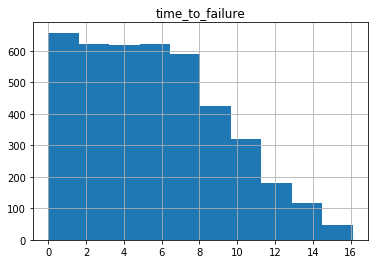

In [52]:
data.hist(column='time_to_failure')#.show()

In [122]:
meta_model =  Lasso(positive=True, alpha=0.5)
meta_model.fit(stacked.drop('target',axis=1), stacked['target'])

from sklearn.metrics import mean_absolute_error

meta_preds = meta_model.predict(stacked.drop('target',axis=1))
print("mae: ", mean_absolute_error(meta_preds, stacked['target']))

mae:  2.131716731112961


In [123]:
meta_model.coef_

array([0.44301687, 0.12964423, 0.40689408, 0.        , 0.        ])

In [92]:
TEST_SPLITS='test'
test_splits = [f for f in listdir(TEST_SPLITS) if isfile(join(TEST_SPLITS, f))]

In [93]:
test_split_chunks = np.array_split(test_splits,mp.cpu_count())
    
    
param_test = True
param_augment = False
param_scale = False
param_noise = 0.6


if __name__ ==  '__main__':
    pool = mp.Pool(mp.cpu_count())
    test_res = [pool.apply_async(build_segment_f,args=[chunk,TIMESTEPS,param_test,param_augment,param_scale,param_noise]) for chunk in test_split_chunks]
    pool.close()
    pool.join()

0
0
0
0
0
0
0
0
100
100
100
100
100
100
100
100
200
200
200
200
200
200
200
200
300
300
300
300
300
300
300
300


In [94]:
columns=test_res[0].get()[0].columns.values

test_data = pd.DataFrame(columns=columns)


i=0
for r in test_res:
    for df in r.get():
        #print(df)
        test_data = test_data.append(df)
        #print(len(test_data))
        i+=1
        

test_data.reset_index(drop=True,inplace=True)
print(len(test_data))

2624


In [ ]:
combinations2 = list(itertools.combinations(test_data.columns.values, 2))
combinations3 = list(itertools.combinations(test_data.columns.values, 3))


In [ ]:

for combination in combinations2:
    if 'seg_id' in combination or 'time_to_failure' in combination:
        continue
    f1 = combination[0]
    f2 = combination[1]
    feature = f'{f1}_mult_{f2}'
    test_data[feature] = test_data[f1] * test_data[f2]
    feature = f'{f1}_plus_{f2}'
    test_data[feature] = test_data[f1] + test_data[f2]
    feature = f'{f1}_div_{f2}'
    #print(feature)
    test_data[feature] = test_data[f1] / test_data[f2]
    test_data[feature] = pd.to_numeric(test_data[feature], downcast='float')


In [ ]:

for combination in combinations3:
    if 'seg_id' in combination or 'time_to_failure' in combination:
        continue
    f1 = combination[0]
    f2 = combination[1]
    f3 = combination[2]
    feature = f'{f1}_mult_{f2}_mult_{f3}'
    test_data[feature] = test_data[f1] * test_data[f2] * test_data[f3]
    feature = f'{f1}_plus_{f2}_plus_{f3}'
    test_data[feature] = test_data[f1] + test_data[f2] + test_data[f3]
    feature = f'{f1}_div_{f2}_div_{f3}'
    #print(feature)
    test_data[feature] = test_data[f1] / test_data[f2] / test_data[f3]
    test_data[feature] = pd.to_numeric(test_data[feature], downcast='float')
    

In [95]:
ids = test_data['seg_id'].apply(lambda id: id.split('.')[0])

In [97]:
cb_preds = cb_model.predict(test_data[cb_features])
lg_preds = model_lgb.predict(test_data[lg_features])
lr_preds = lr_model.predict(test_data[lr_features])
rf_preds = rf_model.predict(test_data[rf_features])

In [ ]:
lr_preds = lr_model.predict(test_data[lr_features])

In [ ]:
preds = (lg_preds * 0.5) + (lr_preds * 0.5)


In [101]:

submission = pd.DataFrame(ids)
submission.columns = ['seg_id']
submission['time_to_failure'] = rf_preds

submission.to_csv('rf_preds.csv', index=False)

In [ ]:
submission["time_to_failure"].describe()

In [ ]:
submission.head()

In [102]:
cb_preds = pd.read_csv('cb_preds.csv')['time_to_failure']
lg_preds = pd.read_csv('lg_preds.csv')['time_to_failure']
lr_preds = pd.read_csv('lr_preds.csv')['time_to_failure']
rf_preds = pd.read_csv('rf_preds.csv')['time_to_failure']
lstm_preds = pd.read_csv('lstm_preds.csv')['time_to_failure']




In [108]:
np.corrcoef([cb_preds, lg_preds, lr_preds, rf_preds, lstm_preds])

array([[1.        , 0.98685109, 0.93244451, 0.98776879, 0.92942709],
       [0.98685109, 1.        , 0.93064613, 0.98523281, 0.9349964 ],
       [0.93244451, 0.93064613, 1.        , 0.92330153, 0.93254004],
       [0.98776879, 0.98523281, 0.92330153, 1.        , 0.92384266],
       [0.92942709, 0.9349964 , 0.93254004, 0.92384266, 1.        ]])

In [124]:
stacked_test = pd.DataFrame(columns=['cb', 'lg', 'lr', 'rf', 'lstm'])
stacked_test['cb'] = cb_preds
stacked_test['lg'] = lg_preds
stacked_test['lr'] = lr_preds
stacked_test['rf'] = rf_preds
stacked_test['lstm'] = lstm_preds


final_preds = meta_model.predict(stacked_test)


In [125]:
submission = pd.DataFrame(ids)
submission.columns = ['seg_id']
submission['time_to_failure'] = final_preds

submission.to_csv('final_preds.csv', index=False)



In [114]:
submission["time_to_failure"].describe()

count    2624.000000
mean     5.694498   
std      2.444551   
min     -6.191154   
25%      3.691049   
50%      5.144718   
75%      7.775610   
max      11.304780  
Name: time_to_failure, dtype: float64

In [126]:
submission["time_to_failure"].describe()

count    2624.000000
mean     5.642406   
std      2.223331   
min     -4.319585   
25%      3.883431   
50%      5.081091   
75%      7.549768   
max      10.355927  
Name: time_to_failure, dtype: float64